In [44]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from tqdm import notebook as tqdm
from IPython.display import Video
from IPython.display import HTML
import argparse
import sys
import os
import numpy as np
import time
from math import sin, cos, radians, pi
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from matplotlib import animation, rc
import cv2

In [126]:

# 1000 time steps
total_state=1000;
# 5 features on the state [mass,x,y,x_vel,y_vel]
fea_num=5;
# G 
#G = 6.67428e-11;
G=10**5;
# time step
diff_t=0.001;

def init(total_state,n_body,fea_num,orbit):
    data=np.zeros((total_state,n_body,fea_num),dtype=float);
    if(orbit):
        data[0][0][0]=100; #heavy mass at center
        data[0][0][1:5]=0.0; #that does not move
        
        '''For another bodies'''
        for i in range(1,n_body):
            data[0][i][0] = np.random.rand()*8.98+0.02; #mass
            distance = np.random.rand()*90.0+10.0;
            theta = np.random.rand()*360; #angle in degree
            theta_rad = pi/2 - radians(theta)  #angle in radians
            data[0][i][1] = distance*cos(theta_rad); #posx
            data[0][i][2] = distance*sin(theta_rad); #posy
            '''Calc Velocity'''
            pos_norm=norm(data[0][i][1:3]) #norm of the position
            data[0][i][3] = -1*data[0][i][2] / pos_norm * (G*data[0][0][0]/pos_norm**2) * distance/1000; #velx
            data[0][i][4] = data[0][i][1]/pos_norm * (G*data[0][0][0]/pos_norm**2) * distance/1000;    #vely
        
    else:
        for i in range(n_body):
            data[0][i][0]=np.random.rand()*8.98+0.02;
            distance=np.random.rand()*90.0+10.0;
            theta=np.random.rand()*360;
            theta_rad = pi/2 - radians(theta);    
            data[0][i][1]=distance*cos(theta_rad);
            data[0][i][2]=distance*sin(theta_rad);
            data[0][i][3]=np.random.rand()*6.0-3.0;
            data[0][i][4]=np.random.rand()*6.0-3.0;
    return data;      

def norm(x):
    return np.sqrt(np.sum(x**2));

def get_f(reciever,sender):
    diff=sender[1:3]-reciever[1:3];
    distance=norm(diff);
    if(distance<1):
        distance=1;
    return G*reciever[0]*sender[0]/(distance**3)*diff;
 
def calc(cur_state,n_body):
    next_state=np.zeros((n_body,fea_num),dtype=float);
    f_mat=np.zeros((n_body,n_body,2),dtype=float);
    f_sum=np.zeros((n_body,2),dtype=float);
    acc=np.zeros((n_body,2),dtype=float);
    for i in range(n_body):
        for j in range(i+1,n_body):
            if(j!=i):
                f=get_f(cur_state[i][:3],cur_state[j][:3]);  
                f_mat[i,j]+=f;
                f_mat[j,i]-=f;  
        f_sum[i]=np.sum(f_mat[i],axis=0); 
        acc[i]=f_sum[i]/cur_state[i][0];
        next_state[i][0]=cur_state[i][0];
        next_state[i][3:5]=cur_state[i][3:5]+acc[i]*diff_t;
        next_state[i][1:3]=cur_state[i][1:3]+next_state[i][3:5]*diff_t;
    return next_state;

def gen(n_body,orbit):
    # initialization on just first state
    data=init(total_state,n_body,fea_num,orbit);
    for i in tqdm.tqdm(range(1,total_state)):
        data[i]=calc(data[i-1],n_body);
    return data;


    

In [132]:
def transform(data):
    traj=[]
    for body in range(data.shape[1]):
        traj.append(data[:,body,:].T)
    return np.asarray(traj)

def plot_trajectories3D(trajectories,frames=100):
        """Trajectories is a list of list containing a triplet of lists 
           for x, y and z co-ordinates for each object for each instance in time.
        """
           
        fig = plt.figure()
        ax = plt.axes()
        
        
        lines=[]
        empty_xs = []
        empty_ys = []
        empty_zs = []
        for i,_ in enumerate(trajectories):
            des = ['ro-','bo-','go-','ko-','yo-','mo-','co-']
            line, = ax.plot([], [], des[i])
            lines.append(line)
            empty_xs.append([])
            empty_ys.append([])

        # initialization function: plot the background of each frame
        def init():
            for line in lines:
                line.set_data([], [])
                plt.style.use('dark_background')
            return lines

        # animation function. This is called sequentially
        def animate(i):
            for j,traj in enumerate(trajectories):
                if i<len(traj[0]):
                    try:
                        empty_xs[j].append(traj[0][i*int(total_state/frames[-1])])
                        empty_ys[j].append(traj[1][i*int(total_state/frames[-1])]) 

                        lines[j].set_data(empty_xs[j],empty_ys[j])
                        
                    except:
                        pass
                    
            try:
                ax.set_xlim((-5+np.min(empty_xs), 5+np.max(empty_xs)))
                ax.set_ylim((-5+np.min(empty_ys), 5+np.max(empty_ys)))
            except:
                pass

            return (lines)


        # call the animator. blit=True means only re-draw the parts that have changed.
        anim = animation.FuncAnimation(fig, animate, init_func=init,
                                       frames=frames, interval=40, blit=True)

        return anim

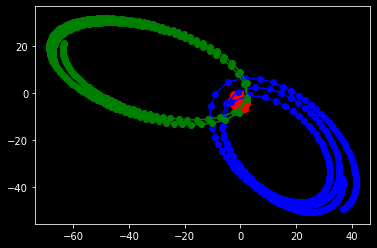

In [134]:
data=gen(3,True);
xy=data[:,:,1:3];
trajectories = transform(xy)
frames = range(250)
anim = plot_trajectories3D(trajectories,frames=frames)
HTML(anim.to_html5_video())